# About

This notebooks aims to compare `rtrgsyl` with scipy's solver against scipy's solver alone. 

# Benchmark

## Utils

In [1]:
from benchmark_utils import benchmark
from utils import solve_sylvester_scipy
from recursive import rtrgsyl

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Format the results of the benchmark() function
def format_results_bs(res_dic):
    df = pd.DataFrame(res_dic)
    df.time = df.time.apply(np.array)
    df['time_schur'] = df.time.apply(lambda lst: [tpl[0] for tpl in lst])
    df['time_solve'] = df.time.apply(lambda lst: [tpl[1] for tpl in lst])
    df['time_back'] = df.time.apply(lambda lst: [tpl[2] for tpl in lst])
    df.drop(columns='time', inplace=True)

    for e in df.columns:
        if e.startswith('time_'):
            df[f'{e}_mean'] = df[e].apply(np.mean)
            df[f'{e}_std'] = df[e].apply(np.std)
    
    df['m'] = df.dim.apply(lambda e: e[0])
    df['n'] = df.dim.apply(lambda e: e[1])
    
    return df

## Vary matrix sizes


In [4]:
blks = 64
nruns_min, nruns_max = (2, 15)
dimensions = np.logspace(2, 3.5, 15)
dimensions = [(int(e), int(e)) for e in dimensions]
dimensions

[(100, 100),
 (127, 127),
 (163, 163),
 (209, 209),
 (268, 268),
 (343, 343),
 (439, 439),
 (562, 562),
 (719, 719),
 (921, 921),
 (1178, 1178),
 (1508, 1508),
 (1930, 1930),
 (2470, 2470),
 (3162, 3162)]

In [5]:
res_rtrgsyl = benchmark(
    solve_fun=rtrgsyl,
    vary_param=('dim', dimensions),
    bartel_stewart=True,
    log_context={'solve_fun': 'rtrgsyl', 'std_solver': 'syl_scipy', 'bartel_stewart': True},
    blks=blks,
    std_solver=solve_sylvester_scipy,
    n_runs=(nruns_min, nruns_max)
)

dim=(100, 100) 15 runs
dim=(127, 127) 14 runs
dim=(163, 163) 13 runs
dim=(209, 209) 12 runs
dim=(268, 268) 11 runs
dim=(343, 343) 10 runs
dim=(439, 439) 9 runs
dim=(562, 562) 8 runs
dim=(719, 719) 7 runs
dim=(921, 921) 6 runs
dim=(1178, 1178) 5 runs
dim=(1508, 1508) 4 runs
dim=(1930, 1930) 3 runs
dim=(2470, 2470) 2 runs
dim=(3162, 3162) 2 runs


In [6]:
df_rtrgsyl = format_results_bs(res_rtrgsyl)
df_rtrgsyl.head(2)

,blks,std_solver,dim,solve_fun,bartel_stewart,time_schur,time_solve,time_back,time_schur_mean,time_schur_std,time_solve_mean,time_solve_std,time_back_mean,time_back_std,m,n
0,64,syl_scipy,"(100, 100)",rtrgsyl,True,"[0.016730546951293945, 0.014522552490234375, 0...","[0.026747703552246094, 0.007695198059082031, 0...","[0.005294084548950195, 0.0067424774169921875, ...",0.021964,0.004994,0.006151,0.005647,0.006246,0.008750,100,100
1,64,syl_scipy,"(127, 127)",rtrgsyl,True,"[0.040088653564453125, 0.03577613830566406, 0....","[0.012207746505737305, 0.01077890396118164, 0....","[0.0021789073944091797, 0.0039479732513427734,...",0.047641,0.022062,0.009774,0.002046,0.006457,0.005144,127,127


In [7]:
res_scipy = benchmark(
    solve_fun=solve_sylvester_scipy,
    vary_param=('dim', dimensions),
    bartel_stewart=True,
    log_context={'solve_fun': 'syl_scipy', 'bartel_stewart': True},
    n_runs=(nruns_min, nruns_max)
)

dim=(100, 100) 15 runs
dim=(127, 127) 14 runs
dim=(163, 163) 13 runs
dim=(209, 209) 12 runs
dim=(268, 268) 11 runs
dim=(343, 343) 10 runs
dim=(439, 439) 9 runs
dim=(562, 562) 8 runs
dim=(719, 719) 7 runs
dim=(921, 921) 6 runs
dim=(1178, 1178) 5 runs
dim=(1508, 1508) 4 runs
dim=(1930, 1930) 3 runs
dim=(2470, 2470) 2 runs
dim=(3162, 3162) 2 runs


In [8]:
df_scipy = format_results_bs(res_scipy)
df_scipy.head(2)

,dim,solve_fun,bartel_stewart,time_schur,time_solve,time_back,time_schur_mean,time_schur_std,time_solve_mean,time_solve_std,time_back_mean,time_back_std,m,n
0,"(100, 100)",syl_scipy,True,"[0.018348217010498047, 0.012748003005981445, 0...","[0.0065762996673583984, 0.007719993591308594, ...","[0.00010848045349121094, 0.0001044273376464843...",0.012294,0.001888,0.008063,0.001689,0.000106,0.000008,100,100
1,"(127, 127)",syl_scipy,True,"[0.02109527587890625, 0.02344059944152832, 0.0...","[0.012962579727172852, 0.012353181838989258, 0...","[0.0001888275146484375, 0.00019216537475585938...",0.023765,0.005186,0.014435,0.003145,0.000195,0.000049,127,127


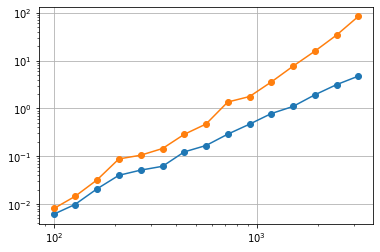

In [9]:
plt.loglog(df_rtrgsyl.n, df_rtrgsyl.time_solve_mean, '-o', label='rtrgsyl')
plt.loglog(df_scipy.n, df_scipy.time_solve_mean, '-o', label='rtrgsyl')
plt.grid()

## Save results

In [10]:
import json

res_dump = res_rtrgsyl + res_scipy

with open('res/benchmark_rtrgsyl.json', 'w') as f:
    json.dump(res_dump, f)

# Produce plots

In [11]:
from ipypublish import nb_setup
plt = nb_setup.setup_matplotlib()
import seaborn as sns
sns.set(style='whitegrid')

/home/maousi/miniconda3/envs/ada/lib/python3.9/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams[key] = val
/home/maousi/miniconda3/envs/ada/lib/python3.9/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams[key] = val
/home/maousi/miniconda3/envs/ada/lib/python3.9/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams[key] = val
/home/maousi/miniconda3/envs/ada/lib/python3.9/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecati

In [12]:
def plot_multiple_runs(df, x, y, ystd, label, color):
    plt.plot(df[x], df[y], '-o', label=label, color=color)
    plt.fill_between(df[x], df[y] - df[ystd], df[y] + df[ystd], alpha=.4, color=color)

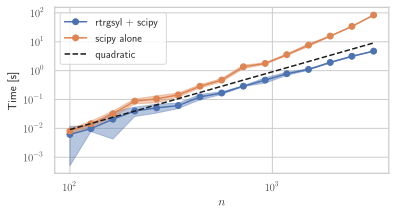

In [13]:
cols = sns.color_palette()

plt.figure(figsize=(6, 3))

plot_multiple_runs(df_rtrgsyl, 'n', 'time_solve_mean', 'time_solve_std', 'rtrgsyl + scipy', cols[0])
plot_multiple_runs(df_scipy, 'n', 'time_solve_mean', 'time_solve_std', 'scipy alone', cols[1])

point = np.array([df_rtrgsyl.n.min(), df_rtrgsyl.n.max()])
plt.loglog(point, point**2 / 1100000, '--k', label='quadratic')

plt.xlabel('$n$'); plt.ylabel('Time [s]')
plt.legend();
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, LogLocator)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.savefig('res/benchmark_retrgsyl_vs_scipy.pdf', bbox_inches='tight')

# Determine slopes

In [14]:
df = pd.concat((df_rtrgsyl, df_scipy)).reset_index(drop=True)[['n', 'time_solve_mean', 'solve_fun']]
df['logn'] = np.log(df.n)
df['logtime'] = np.log(df.time_solve_mean)
df.rename(columns={'solve_fun': 'fun'}, inplace=True)

df = df[df.n > 1000]
df

,n,time_solve_mean,fun,logn,logtime
10,1178,0.779646,rtrgsyl,7.071573,-0.248916
11,1508,1.099101,rtrgsyl,7.318540,0.094493
12,1930,1.921060,rtrgsyl,7.565275,0.652877
13,2470,3.137652,rtrgsyl,7.811973,1.143475
14,3162,4.728846,rtrgsyl,8.058960,1.553681
25,1178,3.566473,syl_scipy,7.071573,1.271577
26,1508,7.633903,syl_scipy,7.318540,2.032599
27,1930,15.697096,syl_scipy,7.565275,2.753476
28,2470,34.091600,syl_scipy,7.811973,3.529051
29,3162,83.841794,syl_scipy,8.058960,4.428932


In [15]:
from sklearn.linear_model import LinearRegression

In [24]:
regline_rtrgsyl = LinearRegression().fit(df.loc[df.fun == 'rtrgsyl', 'logn'].values.reshape(-1, 1), 
                                         df.loc[df.fun == 'rtrgsyl', 'logtime'].values.reshape(-1, 1))
regline_scipy   = LinearRegression().fit(df.loc[df.fun == 'syl_scipy', 'logn'].values.reshape(-1, 1), 
                                         df.loc[df.fun == 'syl_scipy', 'logtime'].values.reshape(-1, 1))

In [25]:
slope_rtrgsyl = regline_rtrgsyl.coef_[0, 0]
slope_scipy = regline_scipy.coef_[0, 0]

slope_rtrgsyl, slope_scipy

(1.8856260511995822, 3.1647242198074976)

In [18]:
regline_rtrgsyl.coef_

array([[1.88562605]])

In [19]:
regline_rtrgsyl.intercept_

array([-13.62613755])

Sanity check:

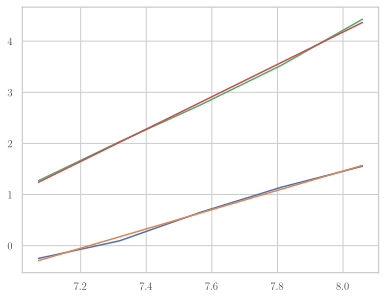

In [20]:
grid = np.linspace(min(df.logn), max(df.logn), 10)

plt.plot(df.loc[df.fun == 'rtrgsyl', 'logn'], df.loc[df.fun == 'rtrgsyl', 'logtime'])
plt.plot(grid, grid * slope_rtrgsyl + regline_rtrgsyl.intercept_)

plt.plot(df.loc[df.fun == 'syl_scipy', 'logn'], df.loc[df.fun == 'syl_scipy', 'logtime'])
plt.plot(grid, grid * slope_scipy + regline_scipy.intercept_)